In [173]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime


In [166]:
# if code was already run, to save time :
sessions = pd.read_csv("data/enriched_sessions.csv")


## 1: Gather and concatenate the pre-processed data

In [174]:
logs_df = pd.read_csv("data/clean_logs.csv")

In [175]:
arks_df = pd.read_csv("arks_final/arks_non_empty.csv")

In [176]:
# Merge DataFrames based on the 'Ark' column, keeping all rows from 'logs_df'
logs_arks_df = pd.merge(logs_df, arks_df, on='Ark', how='left')

In [177]:
logs_arks_df.columns

Index(['Unnamed: 0_x', '0', 'IPaddress', 'Country', 'City', 'Full_request',
       'Date', 'Request', 'Referrer', 'Ark', 'search_terms', 'visibility',
       'Unnamed: 0_y', 'Theme', 'Type'],
      dtype='object')

In [178]:
logs_arks_df = logs_arks_df.drop(['0', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)

In [179]:
len(logs_arks_df)

10042040

In [180]:
known_type_mask = logs_arks_df['Type'].notna() & logs_arks_df['Theme'].isna()
# Replacing 'Theme' values with 'unknown' in rows where both 'Theme' and 'Type' are NaN
logs_arks_df.loc[known_type_mask, 'Theme'] = -1

In [181]:
# logs_arks_df['Date'] = pd.to_datetime(logs_arks_df['Date'], format='%d/%b/%Y:%H:%M:%S %z')

In [182]:
logs_arks_df['Type'].unique()

array(['monographie', 'fascicule', nan, 'manuscrit', 'carte', 'image',
       'sonore', 'partition', 'objet'], dtype=object)

## 2: Sessionization

Create user sessions. The goal will then be to classify these sessions and find the ones relating to a "rabbit hole".

In [183]:
print(logs_arks_df.columns)

Index(['IPaddress', 'Country', 'City', 'Full_request', 'Date', 'Request',
       'Referrer', 'Ark', 'search_terms', 'visibility', 'Theme', 'Type'],
      dtype='object')


In [184]:
sessions_df = logs_arks_df.groupby('IPaddress').agg({'Ark':list, 'Date':list, 'search_terms':list, 'Theme':list, 'Type':list, 'visibility':list})


In [185]:
sessions_df

,Ark,Date,search_terms,Theme,Type,visibility
IPaddress,,,,,,
1000bc3556ab2bdab322bc1f8a50bb,"[bpt6k61150980, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:23:47:53 +0100, 31/Jan/2016:23:47...","[[], [], [], [], [], [], [], [], [], [], [], [...","[35.0, nan, nan, nan, nan, nan, nan, nan, nan,...","[monographie, nan, nan, nan, nan, nan, nan, na...","[1.613218031396011e-05, 0.0, 0.0, 0.0, 0.0, 0...."
1000f948491d5a04bd2840f7fb88ed65,"[bpt6k6421786z, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:19:46:57 +0100, 31/Jan/2016:19:46...","[[], [], [], [], [], [], [], [], [], [], [], [...","[944.0, nan, nan, nan, nan, nan, nan, nan, nan...","[monographie, nan, nan, nan, nan, nan, nan, na...","[8.962322396644507e-07, 0.0, 0.0, 0.0, 0.0, 0...."
1003da47f36bd25814a5e9a122c2a06,[btv1b7200184d],[01/Feb/2016:03:31:43 +0100],[[]],[-1.0],[carte],[7.966508797017339e-07]
10065744baf96c51f9e7572be073930,"[bpt6k6578972d, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:23:53:22 +0100, 31/Jan/2016:23:53...","[[], [], [], [], [], [], [], [], [], [], [], [...","[49.0, nan, nan, nan, nan, nan, nan, nan, nan,...","[monographie, nan, nan, nan, nan, nan, nan, na...","[1.493720399440751e-06, 0.0, 0.0, 0.0, 0.0, 0...."
100754cd2af3e3088b8a599e3e8390f8,[bpt6k5451318c],[31/Jan/2016:21:15:45 +0100],[[]],[32.0],[monographie],[9.958135996271675e-08]
...,...,...,...,...,...,...
fff32ef908e4629af3e52cd235ec1c32,"[btv1b7300052b, btv1b8432364g, bpt6k88355457, ...","[31/Jan/2016:20:52:19 +0100, 31/Jan/2016:21:44...","[[], [], [], [], [], [], [], [], [], [], [], [...","[-1.0, -1.0, -1.0, -1.0, -1.0, 34.0, 35.0, 93....","[fascicule, image, sonore, image, monographie,...","[2.987440798881502e-07, 1.991627199254335e-07,..."
fff57715ba27f512437b38d7f39786ca,"[bpt6k6200413p, bpt6k6200413p, bpt6k6200413p, ...","[31/Jan/2016:16:00:36 +0100, 31/Jan/2016:16:00...","[[], [], [], [], [], [], [], [], [], [], [], [...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[6.572369757539304e-06, 6.572369757539304e-06,..."
fff61a029ac91222c15459276b972d22,"[nan, nan]","[31/Jan/2016:13:43:02 +0100, 31/Jan/2016:13:43...","[[], []]","[nan, nan]","[nan, nan]","[0.0, 0.0]"


In [186]:
# function to compute minutes between to dates
def minutes_between(d1, d2):
    d1 = datetime.strptime(d1, "%d/%b/%Y:%H:%M:%S")
    d2 = datetime.strptime(d2, "%d/%b/%Y:%H:%M:%S")
    return abs(((d2 - d1)).total_seconds() // 60.0)

In [187]:
time_beginning = "01/Jan/0001:01:01:01 +0100"
time_end = "01/Jan/3000:01:01:01 +0100"
sessions_df['date_1'] = sessions_df.apply(lambda x: [time_beginning]+x['Date'], axis = 1)
sessions_df['date_2'] = sessions_df.apply(lambda x: x['Date']+[time_end],axis=1)

In [188]:
'''
Function to calculate the difference between two zipped lists
'''
def calculate_difference_zipped_list(lst):
    new_lst = []
    for e in lst:
        if (e[0]==time_beginning):
            new_lst.append(999)
        elif (e[1]==time_end):
            new_lst.append(999)
        else:
            new_lst.append(minutes_between(e[0][:-6], e[1][:-6]))
    return new_lst
        
# 999 : this is the first connection    

In [189]:
# this contains the ip adress and the zipped version of date_1, date_2
IP_and_sessions = sessions_df.apply(lambda x: deque(calculate_difference_zipped_list(list(zip(x['date_1'],x['date_2'])))),axis=1)

In [190]:
# IP and the difference in time between each connection and the last
IP_and_sessions

IPaddress
1000bc3556ab2bdab322bc1f8a50bb      [999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1000f948491d5a04bd2840f7fb88ed65    [999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1003da47f36bd25814a5e9a122c2a06                                            [999, 999]
10065744baf96c51f9e7572be073930     [999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
100754cd2af3e3088b8a599e3e8390f8                                           [999, 999]
                                                          ...                        
fff32ef908e4629af3e52cd235ec1c32    [999, 52.0, 1.0, 5.0, 4.0, 6.0, 1.0, 1.0, 2.0,...
fff57715ba27f512437b38d7f39786ca    [999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
fff61a029ac91222c15459276b972d22                                      [999, 0.0, 999]
fffa275839e09e5c9f0dc11d2359a413                                      [999, 0.0, 999]
fffd4f62954e7e5c4660f8c44917cd82                                           [999, 999]
Length: 43214, dtype: object

In [191]:
# index on ipaddress/date
# queue 
logs_arks_df['previous_connexion_date'] = logs_arks_df.apply(lambda x: IP_and_sessions[x['IPaddress']].popleft(),axis=1)

In [192]:
logs_arks_df.head(2)

,IPaddress,Country,City,Full_request,Date,Request,Referrer,Ark,search_terms,visibility,Theme,Type,previous_connexion_date
0,e7fdec50f50253f6796d61b5382155f8,NaN,NaN,"- - [31/Jan/2016:18:59:19 +0100] ""GET /ark:/12...",31/Jan/2016:18:59:19 +0100,GET /ark:/12148/bpt6k70211m,-,bpt6k70211m,[],9.643857e-03,84.0,monographie,999.0
1,5d1edaaaa9cf4772ce828127ce3e523a,United States,Chapel Hill,"- - [31/Jan/2016:18:59:20 +0100] ""GET /ark:/12...",31/Jan/2016:18:59:20 +0100,GET /ark:/12148/bpt6k622723.planchecontact.r=e...,-,bpt6k622723,[],4.979068e-07,70.0,monographie,999.0


In [193]:
session_id = 0

# generate session IDs based on period, a new session ID is generated if the period between the last connexion
# and this one is > 60
def create_session(period):
    global session_id
    if(period > 60):
        session_id += 1
    return session_id


In [194]:
logs_arks_df = logs_arks_df.sort_values(by=['IPaddress','Date'])
# create session ids, a new session is created if the previous connexion was more than 60 minutes ago
logs_arks_df['session_id'] = logs_arks_df.apply(lambda x: create_session(x['previous_connexion_date']),axis=1)

In [195]:
logs_arks_df

,IPaddress,Country,City,Full_request,Date,Request,Referrer,Ark,search_terms,visibility,Theme,Type,previous_connexion_date,session_id
7911738,1000bc3556ab2bdab322bc1f8a50bb,France,Mons-en-Barœul,"- - [31/Jan/2016:23:47:53 +0100] ""GET /ark:/12...",31/Jan/2016:23:47:53 +0100,GET /ark:/12148/bpt6k61150980,http://genealogielibre.jimdo.com/sites-g%C3%A9...,bpt6k61150980,[],1.613218e-05,35.0,monographie,999.0,1
7911739,1000bc3556ab2bdab322bc1f8a50bb,France,Mons-en-Barœul,"- - [31/Jan/2016:23:47:53 +0100] ""GET /assets/...",31/Jan/2016:23:47:53 +0100,GET /assets/static/stylesheets/vendor/bootstra...,http://gallica.bnf.fr/ark:/12148/bpt6k61150980,NaN,[],0.000000e+00,NaN,NaN,0.0,1
7911740,1000bc3556ab2bdab322bc1f8a50bb,France,Mons-en-Barœul,"- - [31/Jan/2016:23:47:53 +0100] ""GET /assets/...",31/Jan/2016:23:47:53 +0100,GET /assets/static/stylesheets/main.css,http://gallica.bnf.fr/ark:/12148/bpt6k61150980,NaN,[],0.000000e+00,NaN,NaN,0.0,1
7911741,1000bc3556ab2bdab322bc1f8a50bb,France,Mons-en-Barœul,"- - [31/Jan/2016:23:47:53 +0100] ""GET /assets/...",31/Jan/2016:23:47:53 +0100,GET /assets/static/stylesheets/panes.css,http://gallica.bnf.fr/ark:/12148/bpt6k61150980,NaN,[],0.000000e+00,NaN,NaN,0.0,1
7911742,1000bc3556ab2bdab322bc1f8a50bb,France,Mons-en-Barœul,"- - [31/Jan/2016:23:47:53 +0100] ""GET /assets/...",31/Jan/2016:23:47:53 +0100,GET /assets/static/stylesheets/tablet/panes.css,http://gallica.bnf.fr/ark:/12148/bpt6k61150980,NaN,[],0.000000e+00,NaN,NaN,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590661,fff61a029ac91222c15459276b972d22,France,Francheville,"- - [31/Jan/2016:13:43:02 +0100] ""GET /docume...",31/Jan/2016:13:43:02 +0100,GET /documents.xml,-,NaN,[],0.000000e+00,NaN,NaN,999.0,56432
590663,fff61a029ac91222c15459276b972d22,France,Francheville,"- - [31/Jan/2016:13:43:10 +0100] ""GET /docume...",31/Jan/2016:13:43:10 +0100,GET /documents.xml,-,NaN,[],0.000000e+00,NaN,NaN,0.0,56432
6223916,fffa275839e09e5c9f0dc11d2359a413,Italy,Bolzano,"- - [31/Jan/2016:19:34:32 +0100] ""GET /ark:/1...",31/Jan/2016:19:34:32 +0100,GET /ark:/12148/btv1b6933134r/f1.highres,http://vangoghiamo.altervista.org/?m=201503,btv1b6933134r,[],3.983254e-07,-1.0,image,999.0,56433
6223921,fffa275839e09e5c9f0dc11d2359a413,Italy,Bolzano,"- - [31/Jan/2016:19:34:34 +0100] ""GET /ark:/1...",31/Jan/2016:19:34:34 +0100,GET /ark:/12148/btv1b6923678c/f1.highres,http://vangoghiamo.altervista.org/?m=201503,btv1b6923678c,[],4.979068e-07,-1.0,image,0.0,56433


In [196]:
# Check if 'Ark' is NaN
no_ark_type_mask = logs_arks_df['Ark'].isna()

# Replace 'Theme' and 'Type' values with 'no_ark' where 'Ark' is NaN
logs_arks_df.loc[no_ark_type_mask, ['Theme', 'Type']] = -2, 'no_ark'

In [197]:
#create sessions by grouping by session ID and collecting all arks
sessions = logs_arks_df.groupby('session_id').agg({'Ark':list,'Date':list, 'Country':list,'City':list, 'search_terms':list, 'Theme':list, 'Type':list, 'visibility':list})



In [198]:
# removing subsequent ARKs and remove empty lists
def remove_consecutive_duplicates(l):
    return [v for i, v in enumerate(l) if (i == 0 or v != l[i-1]) and v!=[]]

    
sessions['Ark'] = sessions.apply(lambda x: remove_consecutive_duplicates(x['Ark']), axis = 1)

In [199]:
# keep sessions with more than one ark
sessions = sessions[sessions['Ark'].apply(lambda x: len(x)>1)]

In [200]:
# keep only 1 country, 1 city, first and last dates
sessions['Country'] = sessions['Country'].apply(lambda x: x[0])
sessions['City']= sessions['City'].apply(lambda x: x[0])
sessions['Date'] = sessions['Date'].apply(lambda x: [x[0],x[-1]])

In [201]:
sessions

,Ark,Date,Country,City,search_terms,Theme,Type,visibility
session_id,,,,,,,,
1,"[bpt6k61150980, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:23:47:53 +0100, 31/Jan/2016:23:53...",France,Mons-en-Barœul,"[[], [], [], [], [], [], [], [], [], [], [], [...","[35.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....","[monographie, no_ark, no_ark, no_ark, no_ark, ...","[1.613218031396011e-05, 0.0, 0.0, 0.0, 0.0, 0...."
2,"[bpt6k6421786z, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:19:46:57 +0100, 31/Jan/2016:20:08...",France,Ajaccio,"[[], [], [], [], [], [], [], [], [], [], [], [...","[944.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2...","[monographie, no_ark, no_ark, no_ark, no_ark, ...","[8.962322396644507e-07, 0.0, 0.0, 0.0, 0.0, 0...."
4,"[bpt6k6578972d, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:23:53:22 +0100, 31/Jan/2016:23:53...",France,Haubourdin,"[[], [], [], [], [], [], [], [], [], [], [], [...","[49.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....","[monographie, no_ark, no_ark, no_ark, no_ark, ...","[1.493720399440751e-06, 0.0, 0.0, 0.0, 0.0, 0...."
6,"[btv1b7720797v, btv1b7744855n, btv1b77207988, ...","[31/Jan/2016:20:13:36 +0100, 31/Jan/2016:20:13...",France,Antony,"[[], [], [], []]","[nan, nan, nan, -1.0]","[nan, nan, nan, image]","[9.958135996271675e-08, 4.979067998135837e-07,..."
7,"[btv1b8437169d, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:22:10:05 +0100, 31/Jan/2016:22:10...",France,NaN,"[[], [], [], [], [], [], [], [], [], [], [], [...","[-1.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....","[image, no_ark, no_ark, no_ark, no_ark, no_ark...","[1.095394959589884e-06, 0.0, 0.0, 0.0, 0.0, 0...."
...,...,...,...,...,...,...,...,...
56428,"[bpt6k432545w, bpt6k1051152x, bpt6k5264194, cb...","[31/Jan/2016:19:12:50 +0100, 31/Jan/2016:19:18...",Russia,NaN,"[[], [], [], []]","[70.0, -1.0, 7.0, 7.0]","[fascicule, fascicule, fascicule, fascicule]","[3.98325439850867e-07, 9.958135996271675e-08, ..."
56429,"[btv1b7300052b, btv1b8432364g, bpt6k88355457, ...","[31/Jan/2016:20:52:19 +0100, 31/Jan/2016:23:13...",Russia,NaN,"[[], [], [], [], [], [], [], [], [], [], [], [...","[-1.0, -1.0, -1.0, -1.0, -1.0, 34.0, 35.0, 93....","[fascicule, image, sonore, image, monographie,...","[2.987440798881502e-07, 1.991627199254335e-07,..."
56430,"[bpt6k6200413p, nan, nan, nan, nan, nan, bpt6k...","[31/Jan/2016:16:00:36 +0100, 31/Jan/2016:16:29...",France,Rabastens-de-Bigorre,"[[], [], [], [], [], [], [], [], [], [], [], [...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[6.572369757539304e-06, 6.572369757539304e-06,..."


In [202]:
def length_session(d1, d2):
    d1 = datetime.strptime(d1, "%d/%b/%Y:%H:%M:%S %z")  # Include timezone offset
    d2 = datetime.strptime(d2, "%d/%b/%Y:%H:%M:%S %z")  # Include timezone offset
    return abs((d2 - d1).total_seconds() // 60.0)

sessions['length_minutes'] = sessions['Date'].apply(lambda x: length_session(x[0], x[-1]))

In [203]:
sessions

,Ark,Date,Country,City,search_terms,Theme,Type,visibility,length_minutes
session_id,,,,,,,,,
1,"[bpt6k61150980, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:23:47:53 +0100, 31/Jan/2016:23:53...",France,Mons-en-Barœul,"[[], [], [], [], [], [], [], [], [], [], [], [...","[35.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....","[monographie, no_ark, no_ark, no_ark, no_ark, ...","[1.613218031396011e-05, 0.0, 0.0, 0.0, 0.0, 0....",5.0
2,"[bpt6k6421786z, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:19:46:57 +0100, 31/Jan/2016:20:08...",France,Ajaccio,"[[], [], [], [], [], [], [], [], [], [], [], [...","[944.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2...","[monographie, no_ark, no_ark, no_ark, no_ark, ...","[8.962322396644507e-07, 0.0, 0.0, 0.0, 0.0, 0....",21.0
4,"[bpt6k6578972d, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:23:53:22 +0100, 31/Jan/2016:23:53...",France,Haubourdin,"[[], [], [], [], [], [], [], [], [], [], [], [...","[49.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....","[monographie, no_ark, no_ark, no_ark, no_ark, ...","[1.493720399440751e-06, 0.0, 0.0, 0.0, 0.0, 0....",0.0
6,"[btv1b7720797v, btv1b7744855n, btv1b77207988, ...","[31/Jan/2016:20:13:36 +0100, 31/Jan/2016:20:13...",France,Antony,"[[], [], [], []]","[nan, nan, nan, -1.0]","[nan, nan, nan, image]","[9.958135996271675e-08, 4.979067998135837e-07,...",0.0
7,"[btv1b8437169d, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:22:10:05 +0100, 31/Jan/2016:22:10...",France,NaN,"[[], [], [], [], [], [], [], [], [], [], [], [...","[-1.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....","[image, no_ark, no_ark, no_ark, no_ark, no_ark...","[1.095394959589884e-06, 0.0, 0.0, 0.0, 0.0, 0....",0.0
...,...,...,...,...,...,...,...,...,...
56428,"[bpt6k432545w, bpt6k1051152x, bpt6k5264194, cb...","[31/Jan/2016:19:12:50 +0100, 31/Jan/2016:19:18...",Russia,NaN,"[[], [], [], []]","[70.0, -1.0, 7.0, 7.0]","[fascicule, fascicule, fascicule, fascicule]","[3.98325439850867e-07, 9.958135996271675e-08, ...",5.0
56429,"[btv1b7300052b, btv1b8432364g, bpt6k88355457, ...","[31/Jan/2016:20:52:19 +0100, 31/Jan/2016:23:13...",Russia,NaN,"[[], [], [], [], [], [], [], [], [], [], [], [...","[-1.0, -1.0, -1.0, -1.0, -1.0, 34.0, 35.0, 93....","[fascicule, image, sonore, image, monographie,...","[2.987440798881502e-07, 1.991627199254335e-07,...",140.0
56430,"[bpt6k6200413p, nan, nan, nan, nan, nan, bpt6k...","[31/Jan/2016:16:00:36 +0100, 31/Jan/2016:16:29...",France,Rabastens-de-Bigorre,"[[], [], [], [], [], [], [], [], [], [], [], [...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[6.572369757539304e-06, 6.572369757539304e-06,...",29.0


In [204]:
sessions.to_csv("data_temp/sessions_temp.csv")

## 3: Add features to sessions to later help characterize rabbit holes

In [205]:
sessions['very_long'] = sessions['length_minutes'].apply(lambda x: x >= 120)

In [206]:
sessions['nb_docs'] = sessions['Ark'].apply(lambda x: sum(1 for i in x if not pd.isna(i)))

In [207]:
sessions['>=10_docs'] = sessions['nb_docs'].apply(lambda x: x >= 10)

In [208]:
top_10_threshold = sessions['length_minutes'].quantile(0.9)
top_5_threshold = sessions['length_minutes'].quantile(0.95)
# Create a new column indicating whether each session length is in the top 10%
sessions['top_10%_length'] = sessions['length_minutes'] >= top_10_threshold
# same for top 5%
sessions['top_5%_length'] = sessions['length_minutes'] >= top_5_threshold

In [209]:
sessions['diversified'] = sessions.apply(lambda x: ((len(set(filter(lambda v: v > 0 and not pd.isna(v), x['Theme']))) >= 2) or 
                                                    (len(set(filter(lambda v: v != 'no_ark' and not pd.isna(v), x['Type']))) >= 2)), axis=1)


In [210]:
sessions['diversified_restrictive'] = sessions.apply(lambda x: ((len(set(filter(lambda v: v > 0 and not pd.isna(v), x['Theme']))) >= 2) and 
                                                    (len(set(filter(lambda v: v != 'no_ark' and not pd.isna(v), x['Type']))) >= 2)), axis=1)


In [211]:
sessions['diversified_restrictive_5'] = sessions.apply(lambda x: ((len(set(filter(lambda v: v > 0 and not pd.isna(v), x['Theme']))) >= 5) and 
                                                    (len(set(filter(lambda v: v != 'no_ark' and not pd.isna(v), x['Type']))) >= 5)), axis=1)


In [212]:
sessions['diversified_5'] = sessions.apply(lambda x: ((len(set(filter(lambda v: v > 0 and not pd.isna(v), x['Theme']))) >= 5) or 
                                                    (len(set(filter(lambda v: v != 'no_ark' and not pd.isna(v), x['Type']))) >= 5)), axis=1)


In [213]:
sessions

,Ark,Date,Country,City,search_terms,Theme,Type,visibility,length_minutes,very_long,nb_docs,>=10_docs,top_10%_length,top_5%_length,diversified,diversified_restrictive,diversified_restrictive_5,diversified_5
session_id,,,,,,,,,,,,,,,,,,
1,"[bpt6k61150980, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:23:47:53 +0100, 31/Jan/2016:23:53...",France,Mons-en-Barœul,"[[], [], [], [], [], [], [], [], [], [], [], [...","[35.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....","[monographie, no_ark, no_ark, no_ark, no_ark, ...","[1.613218031396011e-05, 0.0, 0.0, 0.0, 0.0, 0....",5.0,False,5,False,False,False,True,True,False,False
2,"[bpt6k6421786z, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:19:46:57 +0100, 31/Jan/2016:20:08...",France,Ajaccio,"[[], [], [], [], [], [], [], [], [], [], [], [...","[944.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2...","[monographie, no_ark, no_ark, no_ark, no_ark, ...","[8.962322396644507e-07, 0.0, 0.0, 0.0, 0.0, 0....",21.0,False,5,False,False,False,True,False,False,False
4,"[bpt6k6578972d, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:23:53:22 +0100, 31/Jan/2016:23:53...",France,Haubourdin,"[[], [], [], [], [], [], [], [], [], [], [], [...","[49.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....","[monographie, no_ark, no_ark, no_ark, no_ark, ...","[1.493720399440751e-06, 0.0, 0.0, 0.0, 0.0, 0....",0.0,False,2,False,False,False,False,False,False,False
6,"[btv1b7720797v, btv1b7744855n, btv1b77207988, ...","[31/Jan/2016:20:13:36 +0100, 31/Jan/2016:20:13...",France,Antony,"[[], [], [], []]","[nan, nan, nan, -1.0]","[nan, nan, nan, image]","[9.958135996271675e-08, 4.979067998135837e-07,...",0.0,False,4,False,False,False,False,False,False,False
7,"[btv1b8437169d, nan, nan, nan, nan, nan, nan, ...","[31/Jan/2016:22:10:05 +0100, 31/Jan/2016:22:10...",France,NaN,"[[], [], [], [], [], [], [], [], [], [], [], [...","[-1.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....","[image, no_ark, no_ark, no_ark, no_ark, no_ark...","[1.095394959589884e-06, 0.0, 0.0, 0.0, 0.0, 0....",0.0,False,4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56428,"[bpt6k432545w, bpt6k1051152x, bpt6k5264194, cb...","[31/Jan/2016:19:12:50 +0100, 31/Jan/2016:19:18...",Russia,NaN,"[[], [], [], []]","[70.0, -1.0, 7.0, 7.0]","[fascicule, fascicule, fascicule, fascicule]","[3.98325439850867e-07, 9.958135996271675e-08, ...",5.0,False,4,False,False,False,True,False,False,False
56429,"[btv1b7300052b, btv1b8432364g, bpt6k88355457, ...","[31/Jan/2016:20:52:19 +0100, 31/Jan/2016:23:13...",Russia,NaN,"[[], [], [], [], [], [], [], [], [], [], [], [...","[-1.0, -1.0, -1.0, -1.0, -1.0, 34.0, 35.0, 93....","[fascicule, image, sonore, image, monographie,...","[2.987440798881502e-07, 1.991627199254335e-07,...",140.0,True,26,True,True,True,True,True,True,True
56430,"[bpt6k6200413p, nan, nan, nan, nan, nan, bpt6k...","[31/Jan/2016:16:00:36 +0100, 31/Jan/2016:16:29...",France,Rabastens-de-Bigorre,"[[], [], [], [], [], [], [], [], [], [], [], [...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[6.572369757539304e-06, 6.572369757539304e-06,...",29.0,False,18,True,False,False,True,False,False,True


In [214]:
# save enriched sessions
sessions.to_csv("data/enriched_sessions.csv")

## 4 : Create RH sessions dataframe

In [220]:
# keep only sessions that could be qualified as rabbit holes. First keep only top 10% length

sessions_top10_time = sessions[sessions['top_10%_length'] == True].copy()
print("We keep ", len(sessions_top10_time)/len(sessions) * 100, "% of the sessions with the highest time")

# then from the top 10% length we keep only the ones that are diverse
sessions_top10_time_diversified = sessions_top10_time[(sessions_top10_time['diversified'] == True)].copy()
print("We keep ", len(sessions_top10_time_diversified)/len(sessions_top10_time) * 100, "% of the long sessions, which are diversified")
print("diversfied means 2 types of documents or more or 2 dewey classes or more")

sessions_rh_final = sessions_top10_time_diversified[sessions_top10_time_diversified['>=10_docs'] == True].copy()

print("We keep ", len(sessions_rh_final)/len(sessions_top10_time_diversified) * 100, "% of the diversified sessions, which have more than 10 documents")

print("The sessions that could qualify as rabbit holes constitute", len(sessions_rh_final)/len(sessions)*100, "% of all the sessions")                                                                        

We keep  10.067312870220785 % of the sessions with the highest time
We keep  74.1374699117411 % of the long sessions, which are diversified
diversfied means 2 types of documents or more or 2 dewey classes or more
We keep  73.19624819624819 % of the diversified sessions, which have more than 10 documents
The sessions that could qualify as rabbit holes constitute 5.4631125471190085 % of all the sessions


#### Tests to see if 5.46% is a reasonable percentage for the rabbit holes sessions

With a more restrictive diversity metric : 2 types AND 2 Dewey classes instead of 'or'

In [221]:
# diversity more restrictive : and instead of or

# keep only sessions that could be qualified as rabbit holes. First keep only top 10% length

sessions_top10_time = sessions[sessions['top_10%_length'] == True].copy()
print("We keep ", len(sessions_top10_time)/len(sessions) * 100, "% of the sessions with the highest time")

# then from the top 10% length we keep only the ones that have more than 10 docs

sessions_div = sessions_top10_time[(sessions_top10_time['>=10_docs'] == True)].copy()
print("We keep ", len(sessions_div)/len(sessions_top10_time) * 100, "% of the long sessions, which have more than 10 documents")

sessions_rh_test = sessions_div[(sessions_div['diversified_restrictive'] == True)].copy()
print("We keep ", len(sessions_rh_test)/len(sessions_div) * 100, "% of the sessions, which are RH (diversified)")
print("diversfied means 2 types of documents AND more or 2 dewey classes or more")


print("The sessions that could qualify as rabbit holes constitute", len(sessions_rh_test)/len(sessions)*100, "% of all the sessions")                                                                        

We keep  10.067312870220785 % of the sessions with the highest time
We keep  59.13345814388874 % of the long sessions, which have more than 10 documents
We keep  76.61691542288557 % of the sessions, which are RH (diversified)
diversfied means 2 types of documents AND more or 2 dewey classes or more
The sessions that could qualify as rabbit holes constitute 4.561120086160473 % of all the sessions


Then even more restrictive : 5 types and 5 Dewey classes

In [222]:
# keep only sessions that could be qualified as rabbit holes. First keep only top 10% length

sessions_top10_time = sessions[sessions['top_10%_length'] == True].copy()
print("We keep ", len(sessions_top10_time)/len(sessions) * 100, "% of the sessions with the highest time")

# then from the top 10% length we keep only the ones that are diverse
sessions_top10_time_diversified = sessions_top10_time[(sessions_top10_time['diversified_restrictive_5'] == True)].copy()
print("We keep ", len(sessions_top10_time_diversified)/len(sessions_top10_time) * 100, "% of the long sessions, which are diversified")
print("diversfied means 2 types of documents AND 2 dewey classes or more")

sessions_rh_test = sessions_top10_time_diversified[sessions_top10_time_diversified['>=10_docs'] == True].copy()

print("We keep ", len(sessions_rh_test)/len(sessions_top10_time_diversified) * 100, "% of the diversified sessions, which have more than 10 documents")

print("The sessions that could qualify as rabbit holes constitute", len(sessions_rh_test)/len(sessions)*100, "% of all the sessions")                                                                        

We keep  10.067312870220785 % of the sessions with the highest time
We keep  13.907461888205402 % of the long sessions, which are diversified
diversfied means 2 types of documents AND 2 dewey classes or more
We keep  100.0 % of the diversified sessions, which have more than 10 documents
The sessions that could qualify as rabbit holes constitute 1.4001077005923532 % of all the sessions


Final test with 5 types or 5 Dewey classes. We see that we get back to about 5 percent of the sessions.

In [223]:
# diversity more restrictive : and instead of or

# keep only sessions that could be qualified as rabbit holes. First keep only top 10% length

sessions_top10_time = sessions[sessions['top_10%_length'] == True].copy()
print("We keep ", len(sessions_top10_time)/len(sessions) * 100, "% of the sessions with the highest time")

# then from the top 10% length we keep only the ones that have more than 10 docs

sessions_div = sessions_top10_time[(sessions_top10_time['>=10_docs'] == True)].copy()
print("We keep ", len(sessions_div)/len(sessions_top10_time) * 100, "% of the long sessions, which have more than 10 documents")

sessions_rh_test = sessions_div[(sessions_div['diversified_5'] == True)].copy()
print("We keep ", len(sessions_rh_test)/len(sessions_div) * 100, "% of the sessions, which are RH (diversified)")
print("diversfied means 2 types of documents AND 2 dewey classes or more")


print("The sessions that could qualify as rabbit holes constitute", len(sessions_rh_test)/len(sessions)*100, "% of all the sessions")                                                                        

We keep  10.067312870220785 % of the sessions with the highest time
We keep  59.13345814388874 % of the long sessions, which have more than 10 documents
We keep  81.45635459068295 % of the sessions, which are RH (diversified)
diversfied means 2 types of documents AND 2 dewey classes or more
The sessions that could qualify as rabbit holes constitute 4.849219170705439 % of all the sessions


We conclude that rabbit holes representing about 5% of the sessions is a reasonable number.

In [224]:
sessions_rh.to_csv("data/sessions_rh.csv")

In [147]:
# visibility
sessions.loc[:, 'average_visibility'] = sessions['visibility'].apply(lambda x: sum(x) / len(x) if x else 0)

sessions_rh.loc[:, 'average_visibility'] = sessions_rh['visibility'].apply(lambda x: sum(x) / len(x) if x else 0)

sessions.loc[:, 'min_visibility'] = sessions['visibility'].apply(lambda x: min(x) if x else 0)

sessions_rh.loc[:, 'min_visibility'] = sessions_rh['visibility'].apply(lambda x: min(x) if x else 0)

In [148]:
top_10_threshold = sessions['length_minutes'].quantile(0.9)
print("10% of the sessions are longer than :", top_10_threshold)
top_5_threshold = sessions['length_minutes'].quantile(0.95)
print("5% of the sessions are longer than :", top_5_threshold)

10% of the sessions are longer than : 45.0
5% of the sessions are longer than : 95.0


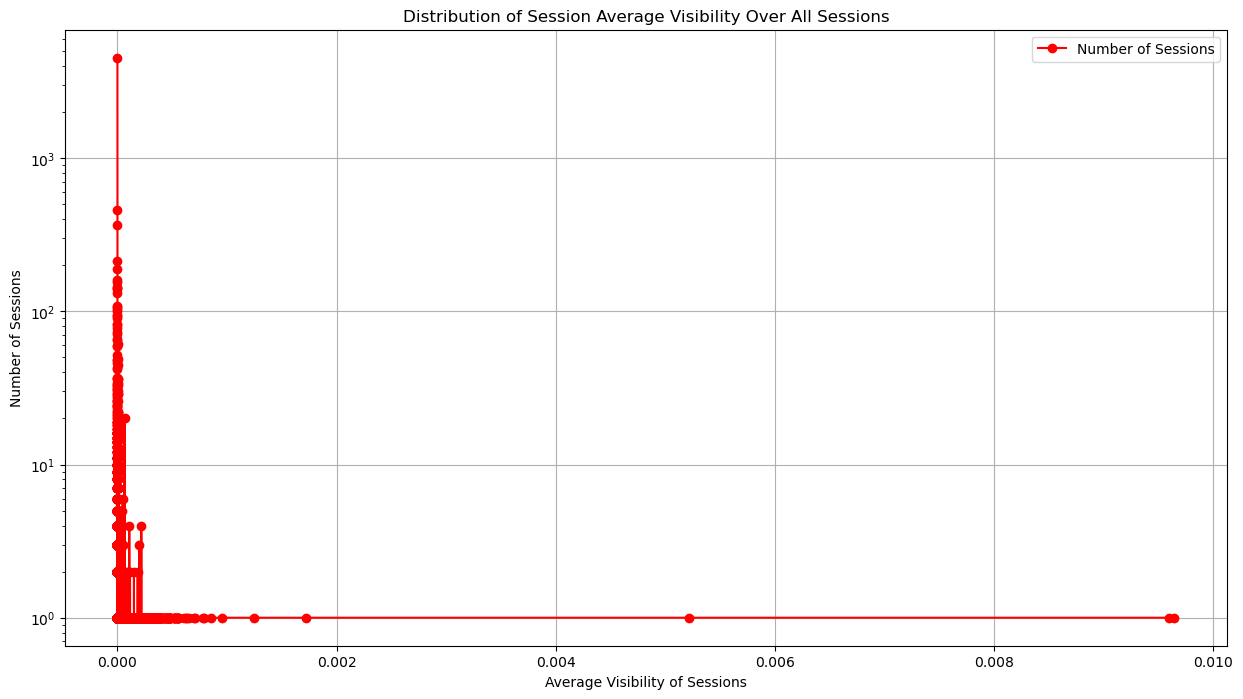

In [149]:
avg_vis = sessions['average_visibility'].value_counts().sort_index()

plt.figure(figsize=(15, 8))

plt.plot(avg_vis.index, avg_vis.values, marker='o', linestyle='-', color='red', label='Number of Sessions')

plt.xlabel('Average Visibility of Sessions')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Average Visibility Over All Sessions')
plt.grid(True)
plt.yscale('log')  # Set log scale for y-axis
plt.legend()
plt.show()


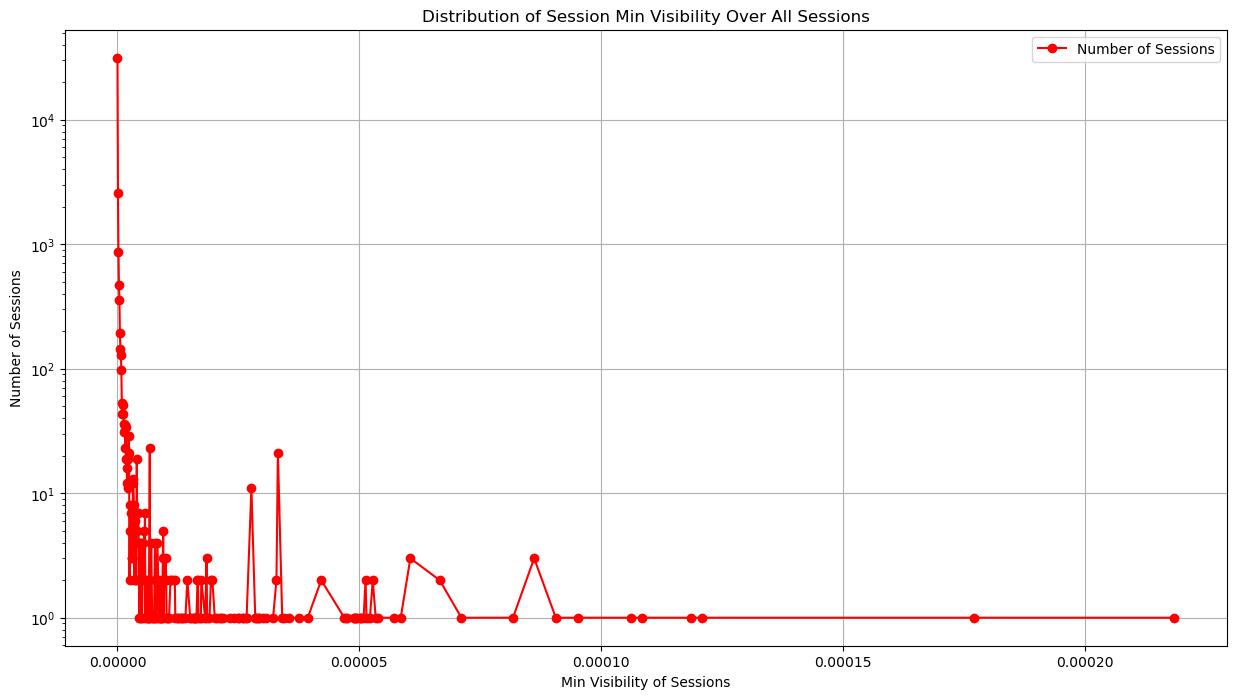

In [151]:
avg_vis = sessions['min_visibility'].value_counts().sort_index()

plt.figure(figsize=(15, 8))

plt.plot(avg_vis.index, avg_vis.values, marker='o', linestyle='-', color='red', label='Number of Sessions')

plt.xlabel('Min Visibility of Sessions')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Min Visibility Over All Sessions')
plt.grid(True)
plt.yscale('log')  # Set log scale for y-axis
plt.legend()
plt.show()


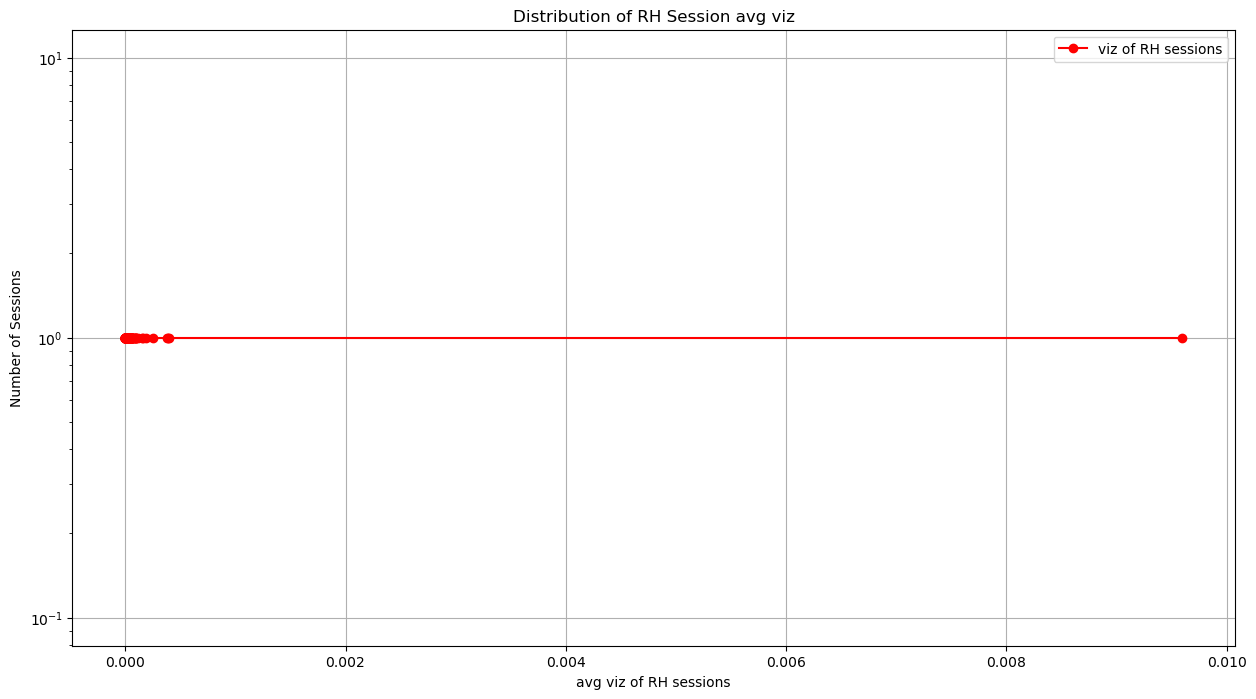

In [155]:

avg_vis = sessions_rh['average_visibility'].value_counts().sort_index()

plt.figure(figsize=(15, 8))

plt.plot(avg_vis.index, avg_vis.values, marker='o', linestyle='-', color='red', label='viz of RH sessions')


plt.xlabel('avg viz of RH sessions')
plt.ylabel('Number of Sessions')
plt.title('Distribution of RH Session avg viz')
plt.grid(True)
plt.yscale('log')  # Set log scale for y-axis
plt.legend()
plt.show()

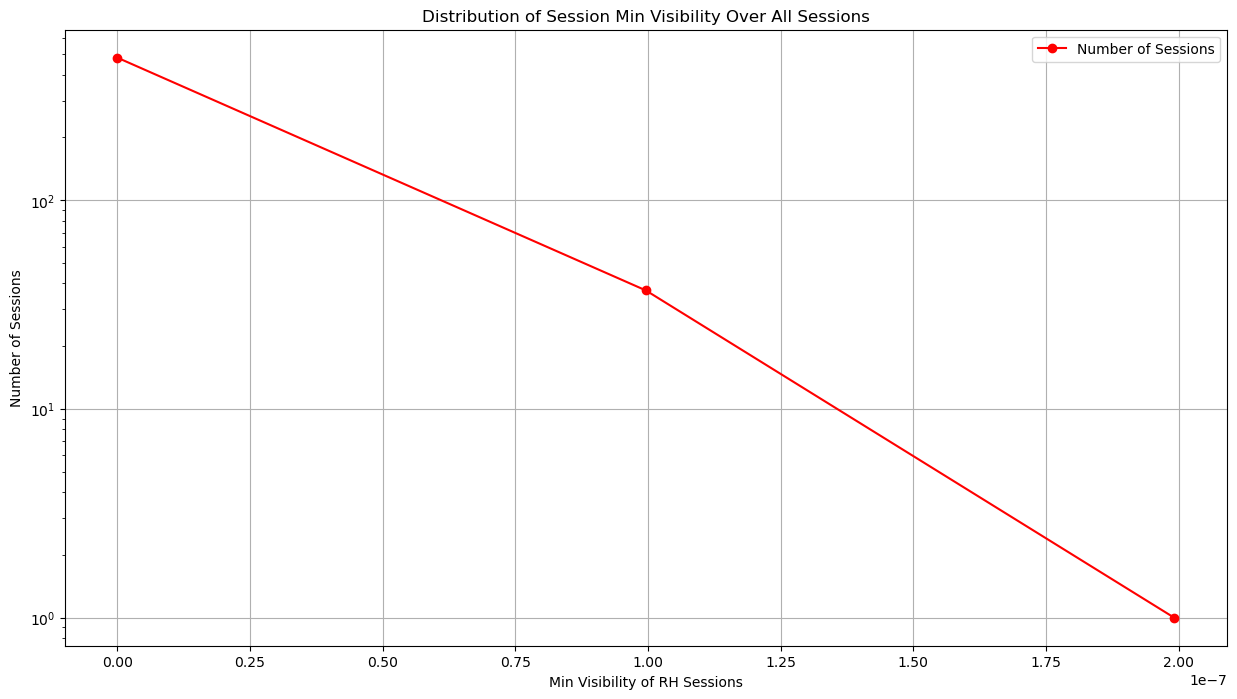

In [156]:
avg_vis = sessions_rh['min_visibility'].value_counts().sort_index()

plt.figure(figsize=(15, 8))

plt.plot(avg_vis.index, avg_vis.values, marker='o', linestyle='-', color='red', label='Number of Sessions')

plt.xlabel('Min Visibility of RH Sessions')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Min Visibility Over All Sessions')
plt.grid(True)
plt.yscale('log')  # Set log scale for y-axis
plt.legend()
plt.show()


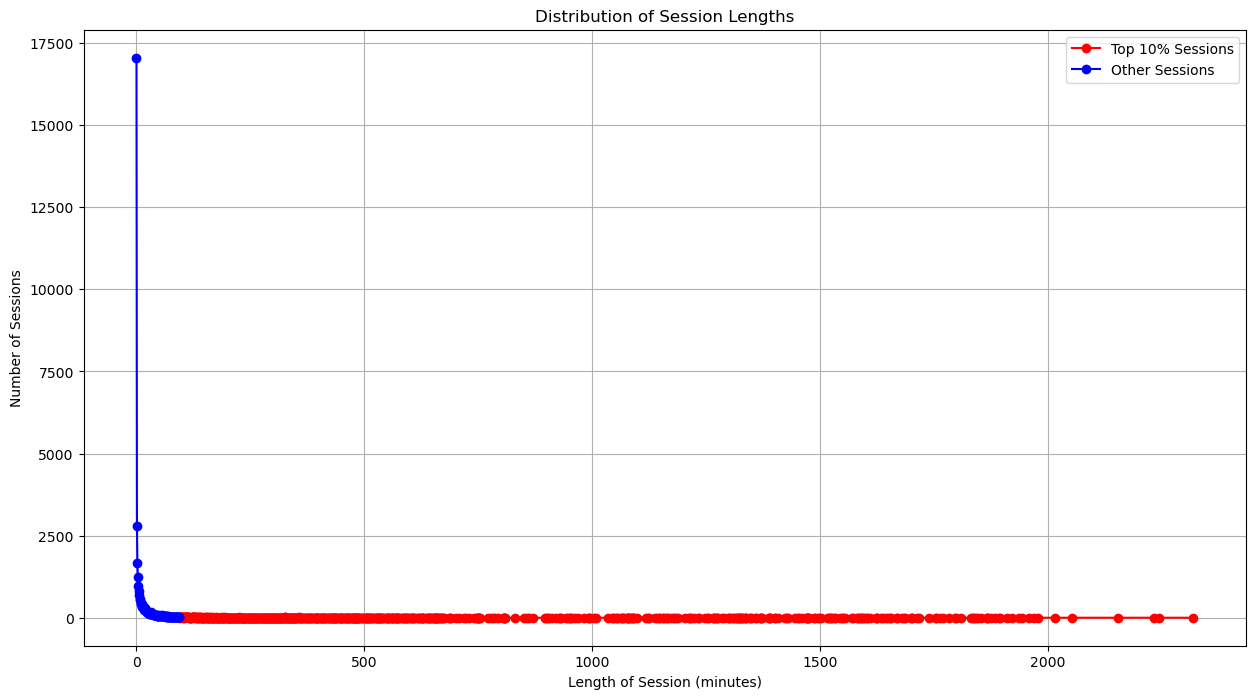

In [135]:
# Separate sessions into top 10% and not in top 10%
top_5_sessions = sessions[sessions['top_5%_length']]
other_sessions = sessions[~sessions['top_5%_length']]

# Calculate session lengths count for top 10% and other sessions
top_5_length_count = top_5_sessions['length_minutes'].value_counts().sort_index()
other_length_count = other_sessions['length_minutes'].value_counts().sort_index()

# Plotting the distribution of session lengths using a line plot
plt.figure(figsize=(15, 8))

# Plot top 10% sessions
plt.plot(top_5_length_count.index, top_5_length_count.values, marker='o', linestyle='-', color='red', label='Top 10% Length Sessions')

# Plot other sessions
plt.plot(other_length_count.index, other_length_count.values, marker='o', linestyle='-', color='blue', label='Other Sessions')

plt.xlabel('Length of Session (minutes)')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Lengths')
plt.grid(True)
plt.legend()
plt.show()


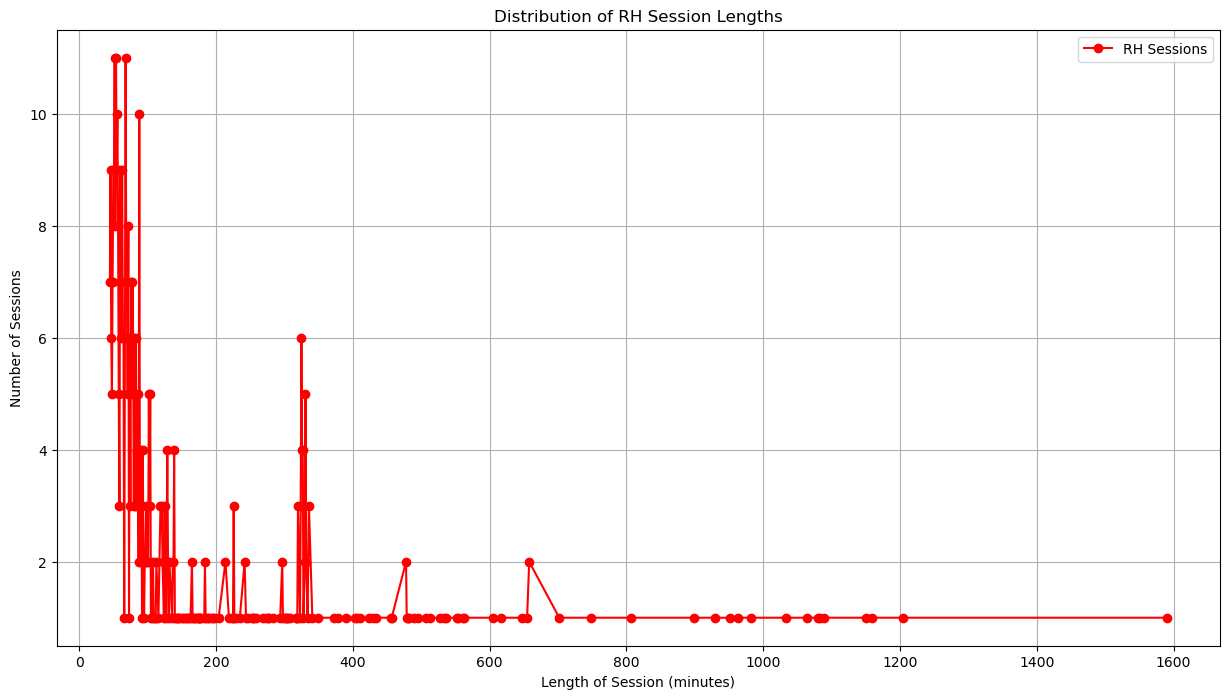

In [157]:
# same stats but on RH
# Calculate session lengths count for top 10% and other sessions
rh_length_count = sessions_rh['length_minutes'].value_counts().sort_index()

# Plotting the distribution of session lengths using a line plot
plt.figure(figsize=(15, 8))

# Plot sessions
plt.plot(rh_length_count.index, rh_length_count.values, marker='o', linestyle='-', color='red', label='RH Sessions')

plt.xlabel('Length of Session (minutes)')
plt.ylabel('Number of Sessions')
plt.title('Distribution of RH Session Lengths')
plt.grid(True)
plt.legend()
plt.show()

